> Martin Fridrich, 03/2022 

# Final project


In [1]:
# try to resolve lgbm on gpu
def check_lgbm_gpu():
  import numpy
  import lightgbm
  print("Testing LGBM & GPU compliance...")
  try:
    lightgbm.LGBMClassifier(device="gpu").\
      fit(numpy.array([0,1]).reshape(-1,1),[1,0])
    print("Great Success!")
    return True
  except:
    print("LGBM not GPU compliant.")
    return False
if not(check_lgbm_gpu()):
  print("Resolving the issues...")
  !pip uninstall -y lightgbm
  !pip install lightgbm --install-option=--gpu
  check_lgbm_gpu()
  exit() # restart the runtime to prevent loading the old pkg version

Testing LGBM & GPU compliance...
Great Success!


In [2]:
# mount project dir
from google.colab import drive
drive.mount("/content/gdrive",  force_remount=True)
%cd gdrive/My Drive/Colab/
#!git clone  https://github.com/fridrichmrtn/hse-advanced-machine-learning
%cd hse-advanced-machine-learning
!git pull
%cd 02_competitive_data_science 
!pip install -r requirements.txt

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab
/content/gdrive/My Drive/Colab/hse-advanced-machine-learning
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/fridrichmrtn/hse-advanced-machine-learning
   1d9a0cd..2202dde  master     -> origin/master
Updating 2a2e58f..2202dde
error: Your local changes to the following files would be overwritten by merge:
	02_competitive_data_science/requirements.txt
	02_competitive_data_science/wk06/final_project.ipynb
Please commit your changes or stash them before you merge.
Aborting
/content/gdrive/My Drive/Colab/hse-advanced-machine-learning/02_competitive_data_science


In [3]:
# set kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Personal/.kaggle"
# download data
!mkdir -p data/final_project
%cd data/final_project
!kaggle competitions download -c competitive-data-science-predict-future-sales
# unpack and remove zips
import os
import glob
for f in glob.glob('*.{}'.format("zip")):
  os.system("unzip "+f); os.system("rm "+f)
# get back
%cd /content/gdrive/MyDrive/Colab/hse-advanced-machine-learning/02_competitive_data_science

/content/gdrive/MyDrive/Colab/hse-advanced-machine-learning/02_competitive_data_science/data/final_project
 33% 5.00M/15.1M [00:00<00:00, 45.7MB/s]
100% 15.1M/15.1M [00:00<00:00, 88.6MB/s]
/content/gdrive/MyDrive/Colab/hse-advanced-machine-learning/02_competitive_data_science


## Data loading

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import seaborn as sns
import gc
from itertools import product
import re
from fuzzywuzzy import fuzz

In [5]:
DATA_DIR = "data/final_project/"
# sales
sales_train = pd.read_csv(DATA_DIR+"sales_train.csv")
sales_test = pd.read_csv(DATA_DIR+"test.csv")
# addional info
items = pd.read_csv(DATA_DIR+"items.csv")
item_categories = pd.read_csv(DATA_DIR+"item_categories.csv")
shops = pd.read_csv(DATA_DIR+"shops.csv")

# basic stats related to sales tab
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


## Initial transformations

In [6]:
# downcast dataframe
def optimize_numeric_dtypes(df):
    import pandas as pd
    float_cols = df.select_dtypes("float").columns
    int_cols = df.select_dtypes("integer").columns
    df[float_cols] = df[float_cols].\
        apply(pd.to_numeric, downcast="float")
    df[int_cols] = df[int_cols].\
        apply(pd.to_numeric, downcast="integer")
    return df

def optimize_categories(df):
    import pandas as pd
    cat_cols = df.select_dtypes("object").columns
    df[cat_cols] = df[cat_cols].\
        apply(lambda x: x.astype("category").cat.codes)
    return df    

In [7]:
# duplicate shops
shop_duplicates_map = {0: 57, 1: 58, 11: 10, 40: 39}
sales_train["shop_id"] = sales_train["shop_id"].replace(shop_duplicates_map)
# datetime
sales_train["date"] = pd.to_datetime(sales_train["date"], format="%d.%m.%Y")
# drop training items with extreme or negative prices or sales counts
sales_train = sales_train[((sales_train["item_price"] > 0) & (sales_train["item_price"] <= 50000)) &
    ((sales_train["item_cnt_day"] > 0) & (sales_train["item_cnt_day"] <= 1000))]
# test-based cartesian product & inds
sales_index = pd.DataFrame(product(sales_test.item_id.unique(), sales_test.shop_id.unique(),
    range(35)),columns = ["item_id", "shop_id", "date_block_num"])
sales_index = optimize_numeric_dtypes(sales_index)
# sales table
sales_train["revenue"] = sales_train["item_price"]*sales_train["item_cnt_day"]
sales = sales_train.groupby(["shop_id", "item_id", "date_block_num"], as_index=False).agg(
    total_sold=("item_cnt_day", sum),  sum_revenue=("revenue",sum),
    n_transactions = ("item_cnt_day",pd.Series.count))\
        .sort_values("date_block_num")
# remove items with less than 10 transactions
sales = sales.loc[sales.groupby("item_id").n_transactions.\
  filter(lambda x: sum(x)>9).index,:]

sales = sales_index.merge(sales, how="left",
    on=["shop_id", "item_id", "date_block_num"])
sales["date_block_num"].fillna(34, inplace=True)
sales.loc[sales.date_block_num<34, ["total_sold", "sum_revenue", "n_transactions"]]=\
    sales.loc[sales.date_block_num<34, ["total_sold", "sum_revenue", "n_transactions"]].fillna(0)  
sales = optimize_numeric_dtypes(sales)
del sales_train, sales_test, sales_index; gc.collect(); sales.head(3)   

,item_id,shop_id,date_block_num,total_sold,sum_revenue,n_transactions
0,5037,5,0,0.0,0.0,0.0
1,5037,5,1,0.0,0.0,0.0
2,5037,5,2,0.0,0.0,0.0


## Exploration

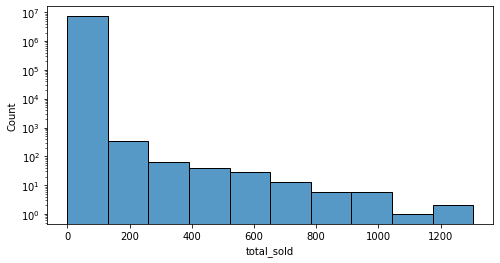

In [8]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
hist = sns.histplot(data=sales, x="total_sold", bins=10,
    palette=sns.color_palette("husl"))
hist.set_yscale("log")

In [9]:
# top 5 items
sales.groupby("item_id")["total_sold"].sum().\
    sort_values(ascending=False).head(5)

item_id
20949    154788.0
2808      14016.0
3732      13630.0
17717     13557.0
5822      12303.0
Name: total_sold, dtype: float32

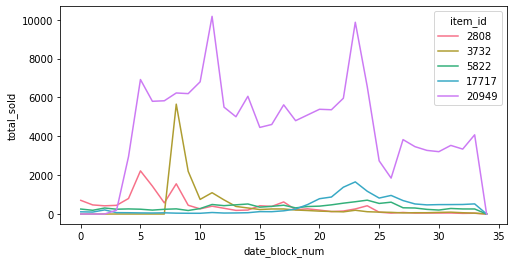

In [10]:
# targets per top 5 items over time
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.lineplot(data=sales[sales.item_id.isin([20949,2808,3732,17717,5822])].\
        groupby(["item_id","date_block_num"], as_index=False)["total_sold"].sum(),
    x="date_block_num", y="total_sold", hue="item_id",
    palette=sns.color_palette("husl", 5));    

In [11]:
# top 5 shops
sales.groupby("shop_id")["total_sold"].sum().\
    sort_values(ascending=False).head(5)

shop_id
31    157472.0
25    120507.0
28     98789.0
42     81652.0
57     69076.0
Name: total_sold, dtype: float32

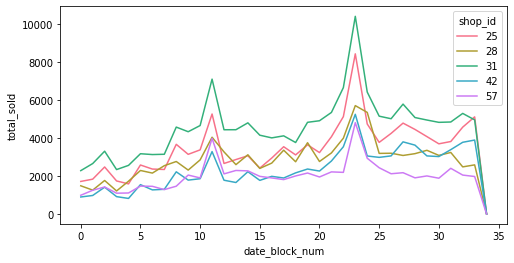

In [12]:
# targets per top 5 items over time
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.lineplot(data=sales[sales.shop_id.isin([31,25,28,42,57])].\
        groupby(["shop_id","date_block_num"], as_index=False)["total_sold"].sum(),
    x="date_block_num", y="total_sold", hue="shop_id",
    palette=sns.color_palette("husl", 5));    

In [13]:
# top 5 categories
sales.merge(items).groupby("item_category_id")["total_sold"].sum().\
    sort_values(ascending=False).head(5)

item_category_id
30    221276.0
55    178377.0
71    154788.0
40    151990.0
19    110086.0
Name: total_sold, dtype: float32

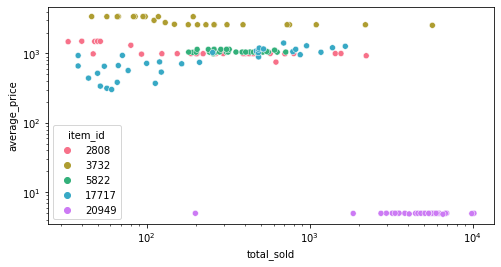

In [14]:
# price vs sales, demand almost inelastic
df = sales[sales.item_id.isin([20949,2808,3732,17717,5822])].\
        groupby(["item_id", "date_block_num"], as_index=False).\
            agg(sum_revenue=("sum_revenue",sum),
            total_sold=("total_sold",sum))
df["average_price"] = df.sum_revenue/df.total_sold
fig, ax = plt.subplots(1,1,figsize=(8,4))
scatter = sns.scatterplot(data=df, x="total_sold", y="average_price",
    hue="item_id", palette=sns.color_palette("husl", 5));
scatter.set_yscale("log"); scatter.set_xscale("log");

## Feature engineering

In [15]:
# item groups based on adjacency and label similarity
items.item_name = items.item_name.apply(lambda x: re.sub("[^A-ZА-Яa-zа-я0-9 ]","", x))
items.item_name = items.item_name.apply(lambda x: re.sub("\\s+"," ", x))
item_names = pd.concat([items.item_id, items.item_name,
    items.item_id.shift().fillna(0), items.item_name.shift().fillna("")], axis=1)
item_names.columns = ["item_id", "item_name", "previous_item_id", "previous_item_name"]
item_names["similarity"] = item_names.apply(\
     lambda x: fuzz.ratio(x["item_name"],x["previous_item_name"]), axis=1)
item_names["group_start"] = item_names["similarity"] <= 75
item_group_map = item_names.loc[item_names.group_start, ["item_id"]]
item_group_map.columns = ["group_start"]
item_group_map["group_end"] = item_group_map["group_start"].shift(-1).\
    fillna(item_group_map["group_start"].max()+1).astype("int")
item_group_map["item_sim_id"] = list(range(len(item_group_map)))
# remap
items = items.merge(item_group_map, how="left",
    left_on=["item_id"], right_on=["group_start"])
items = items.sort_values("item_id")
items["item_sim_id"] = items["item_sim_id"].fillna(method="ffill").astype("int")
del item_names, item_group_map; gc.collect()
items = items[["item_id","item_name", "item_category_id", "item_sim_id"]]
# name length
items["item_name_len"] = items.item_name.apply(len).astype("int16")
items.head(3)

,item_id,item_name,item_category_id,item_sim_id,item_name_len
0,0,ВО ВЛАСТИ НАВАЖДЕНИЯ ПЛАСТ D,40,0,29
1,1,ABBYY FineReader 12 Professional Edition Full ...,76,1,64
2,2,В ЛУЧАХ СЛАВЫ UNV D,40,2,19


In [16]:
# just add some additional text-based features

In [17]:
# categories
cat_splits = item_categories.item_category_name.apply(lambda x: x.split(" - "))
item_categories = pd.concat([item_categories,
    pd.DataFrame([c if len(c)>1 else [c[0],""] for c in cat_splits],
        columns=["parent_cat","child_cat"])], axis=1)
items = items.merge(item_categories, how="inner")
# return categorical encoding
items = optimize_categories(items[["item_id", "item_category_id", "item_sim_id",
    "item_name_len", "parent_cat", "child_cat"]])
# add categories
sales = sales.merge(items, how="inner", on="item_id")
sales["shop_cat_id"] = sales.shop_id*100+sales.item_category_id
del item_categories, items; gc.collect(); sales.head(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,item_id,shop_id,date_block_num,total_sold,sum_revenue,n_transactions,item_category_id,item_sim_id,item_name_len,parent_cat,child_cat,shop_cat_id
0,5037,5,0,0.0,0.0,0.0,19,3286,27,5,13,7
1,5037,5,1,0.0,0.0,0.0,19,3286,27,5,13,7
2,5037,5,2,0.0,0.0,0.0,19,3286,27,5,13,7


In [18]:
# date features
def working_days_count(from_date, to_date=None):
    import pandas as pd
    if to_date is None:
        to_date=from_date+pd.DateOffset(months=1)
    temp_date=from_date
    cnt=0
    while temp_date<to_date:
        if temp_date.weekday()<5:
            cnt+=1
        temp_date+=pd.DateOffset(days=1)
    return ((to_date-from_date).days, cnt, (to_date-from_date).days-cnt)
dates = pd.DataFrame(sales.date_block_num.unique(), columns=["date_block_num"])
dates["date"] = dates["date_block_num"].apply(lambda x: pd.to_datetime("01/01/2013")+\
    pd.DateOffset(months=x))
dates["year"] = dates.date.dt.year
dates["month"] = dates.date.dt.month
dates = optimize_numeric_dtypes(pd.concat([dates, pd.DataFrame.from_records(
        dates["date"].apply(lambda x: working_days_count(x)),
    columns=["total_days", "working_days", "weekend_days"])], axis=1))
sales = sales.merge(dates[["date_block_num","year","month","total_days", "working_days",
    "weekend_days"]], how="inner", on="date_block_num")
del dates; gc.collect(); sales.tail(3)    

,item_id,shop_id,date_block_num,total_sold,sum_revenue,n_transactions,item_category_id,item_sim_id,item_name_len,parent_cat,child_cat,shop_cat_id,year,month,total_days,working_days,weekend_days
7496997,969,44,34,NaN,NaN,NaN,37,646,20,11,2,85,2015,11,30,21,9
7496998,969,39,34,NaN,NaN,NaN,37,646,20,11,2,97,2015,11,30,21,9
7496999,969,45,34,NaN,NaN,NaN,37,646,20,11,2,-71,2015,11,30,21,9


In [19]:
# pricing overall and inside cat
item_pricing = sales.groupby(["date_block_num","item_id","item_category_id"], as_index=False).\
    agg(total_sold=("total_sold", sum),  sum_revenue=("sum_revenue",sum))
train_ind = item_pricing.date_block_num<34
item_pricing.loc[train_ind,"average_price"] = item_pricing["sum_revenue"]/item_pricing["total_sold"]
item_pricing.loc[train_ind,"average_price"]  = item_pricing.groupby(["item_id"])["average_price"].\
    apply(lambda x: x.fillna(method="ffill").fillna(method="bfill"))
# add price changes
item_pricing.loc[train_ind,"price_change"] = item_pricing.groupby(["item_id"])["average_price"].\
    apply(lambda x: x/x.shift()).fillna(-1)
# add position within the category
item_pricing.loc[train_ind,"price_perc"] = item_pricing.groupby(["item_category_id", "date_block_num"])\
    ["average_price"].apply(lambda x: x.rank(pct=True)).fillna(-1)
item_pricing = optimize_numeric_dtypes(item_pricing[["date_block_num", "item_id", "price_change",
    "price_perc"]])
sales = sales.merge(item_pricing, how="left",
    on=["date_block_num", "item_id"])
del item_pricing; gc.collect(); sales.tail(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,item_id,shop_id,date_block_num,total_sold,sum_revenue,n_transactions,item_category_id,item_sim_id,item_name_len,parent_cat,child_cat,shop_cat_id,year,month,total_days,working_days,weekend_days,price_change,price_perc
7496997,969,44,34,NaN,NaN,NaN,37,646,20,11,2,85,2015,11,30,21,9,NaN,NaN
7496998,969,39,34,NaN,NaN,NaN,37,646,20,11,2,97,2015,11,30,21,9,NaN,NaN
7496999,969,45,34,NaN,NaN,NaN,37,646,20,11,2,-71,2015,11,30,21,9,NaN,NaN


In [20]:
# shop location
shops["city_id"] = shops.shop_name.apply(lambda x:\
    re.sub("[^A-ZА-Яa-zа-я0-9 ]","", x.split(" ")[0]))
shops = optimize_categories(shops[["city_id","shop_id"]])
shops["shop_city_id"] = 100*shops.shop_id+shops.city_id
sales = sales.merge(shops, how="inner", on="shop_id")
del shops; gc.collect(); sales.tail(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,item_id,shop_id,date_block_num,total_sold,sum_revenue,n_transactions,item_category_id,item_sim_id,item_name_len,parent_cat,...,shop_cat_id,year,month,total_days,working_days,weekend_days,price_change,price_perc,city_id,shop_city_id
7496997,15757,45,34,NaN,NaN,NaN,55,10515,33,13,...,-53,2015,11,30,21,9,NaN,NaN,20,4520
7496998,19648,45,34,NaN,NaN,NaN,40,13125,25,11,...,-68,2015,11,30,21,9,NaN,NaN,20,4520
7496999,969,45,34,NaN,NaN,NaN,37,646,20,11,...,-71,2015,11,30,21,9,NaN,NaN,20,4520


In [21]:
# time-series
# smoothed demand across various perspectives
train_ind = sales.date_block_num<34
# city
sales.loc[train_ind, "city_demand"] = sales[train_ind].\
    groupby(["city_id","date_block_num"])["total_sold"].apply(lambda x:
        x.ewm(span=3, min_periods=3).mean()).fillna(0)#.astype("float32")
# shop
sales.loc[train_ind, "shop_demand"] = sales[train_ind].\
    groupby(["shop_id","date_block_num"])["total_sold"].apply(lambda x:
        x.ewm(span=3, min_periods=3).mean()).fillna(0)#.astype("float32")
# categories
sales.loc[train_ind, "cat_demand0"] = sales[train_ind].\
    groupby(["parent_cat","date_block_num"])["total_sold"].apply(lambda x:
        x.ewm(span=3, min_periods=3).mean()).fillna(0)#.astype("float32")
# categories
sales.loc[train_ind, "cat_demand1"] = sales[train_ind].\
    groupby(["child_cat","date_block_num"])["total_sold"].apply(lambda x:
        x.ewm(span=3, min_periods=3).mean()).fillna(0)#.astype("float32")      
# categories
sales.loc[train_ind, "cat_demand2"] = sales[train_ind].\
    groupby(["item_sim_id","date_block_num"])["total_sold"].apply(lambda x:
        x.ewm(span=3, min_periods=3).mean()).fillna(0)#.astype("float32")        
# item
sales.loc[train_ind, "item_demand"] = sales[train_ind].\
    groupby(["item_id","date_block_num"])["total_sold"].apply(lambda x:
        x.ewm(span=3, min_periods=3).mean()).fillna(0)#.astype("float32")
# item maturity
sales["item_maturity"] = (sales["date_block_num"] - sales[["item_id","date_block_num"]].merge(\
    sales[sales.n_transactions>0].groupby("item_id", as_index=False).\
        agg(date_block_num_min=("date_block_num",min)),
            how="left")["date_block_num_min"]).clip(-1,34).fillna(-1)
del train_ind; gc.collect();
sales = optimize_numeric_dtypes(sales)
sales.tail(3)

,item_id,shop_id,date_block_num,total_sold,sum_revenue,n_transactions,item_category_id,item_sim_id,item_name_len,parent_cat,...,price_perc,city_id,shop_city_id,city_demand,shop_demand,cat_demand0,cat_demand1,cat_demand2,item_demand,item_maturity
7496997,15757,45,34,NaN,NaN,NaN,55,10515,33,13,...,NaN,20,4520,NaN,NaN,NaN,NaN,NaN,NaN,34.0
7496998,19648,45,34,NaN,NaN,NaN,40,13125,25,11,...,NaN,20,4520,NaN,NaN,NaN,NaN,NaN,NaN,11.0
7496999,969,45,34,NaN,NaN,NaN,37,646,20,11,...,NaN,20,4520,NaN,NaN,NaN,NaN,NaN,NaN,17.0


In [22]:
lag_steps = [1,2,3,6,12]
lag_fill = {"total_sold":0, "sum_revenue":0, "n_transactions":0, "price_change":1, "price_perc":-1,
    "city_demand":0, "shop_demand":0, "cat_demand0":0,"cat_demand1":0,"cat_demand2":0, "item_demand":0}
for l in lag_steps:
    for c in lag_fill.keys():
        sales.loc[:,"lag"+str(l)+"_"+c] = sales.groupby([sales.shop_id,sales.item_id])\
            [c].shift(l).fillna(lag_fill[c])

target = "total_sold"
col_fil = [c for c in sales.columns if (c not in lag_fill.keys()) or (c ==target)]
sales = optimize_numeric_dtypes(sales.loc[:,col_fil])
sales.head(3)

,item_id,shop_id,date_block_num,total_sold,item_category_id,item_sim_id,item_name_len,parent_cat,child_cat,shop_cat_id,...,lag12_sum_revenue,lag12_n_transactions,lag12_price_change,lag12_price_perc,lag12_city_demand,lag12_shop_demand,lag12_cat_demand0,lag12_cat_demand1,lag12_cat_demand2,lag12_item_demand
0,5037,5,0,0.0,19,3286,27,5,13,7,...,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5320,5,0,0.0,55,3489,28,13,5,43,...,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5233,5,0,0.0,19,3438,51,5,13,7,...,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# col filters
target = "total_sold"
cat_cols = ["item_category_id", "item_sim_id", "parent_cat", "child_cat",
  "city_id", "shop_cat_id", "shop_city_id"]
num_cols = [f for f in sales.columns if (f not in cat_cols) &\
  (f not in [target, "item_id", "shop_id", "date_block_num"])]
# target clippin
sales[target] = sales[target].clip(0,20)

In [24]:
# add kfold-based mean encoding
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.wrapper import NestedCVWrapper
te = LeaveOneOutEncoder(cols=cat_cols, sigma=0.05) # for robustness
cvte = NestedCVWrapper(te, cv=5, shuffle=True, random_state=2022)
_ = cvte.fit_transform(sales.loc[sales.date_block_num<34,cat_cols],
  sales.loc[sales.date_block_num<34,target])
encoded = cvte.transform(sales.loc[:,cat_cols])
encoded.columns = ["enc_"+c for c in encoded.columns]
sales = sales.merge(encoded, left_index=True, right_index=True)
features =  list(encoded.columns)+num_cols
del te, cvte, encoded; gc.collect();    

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


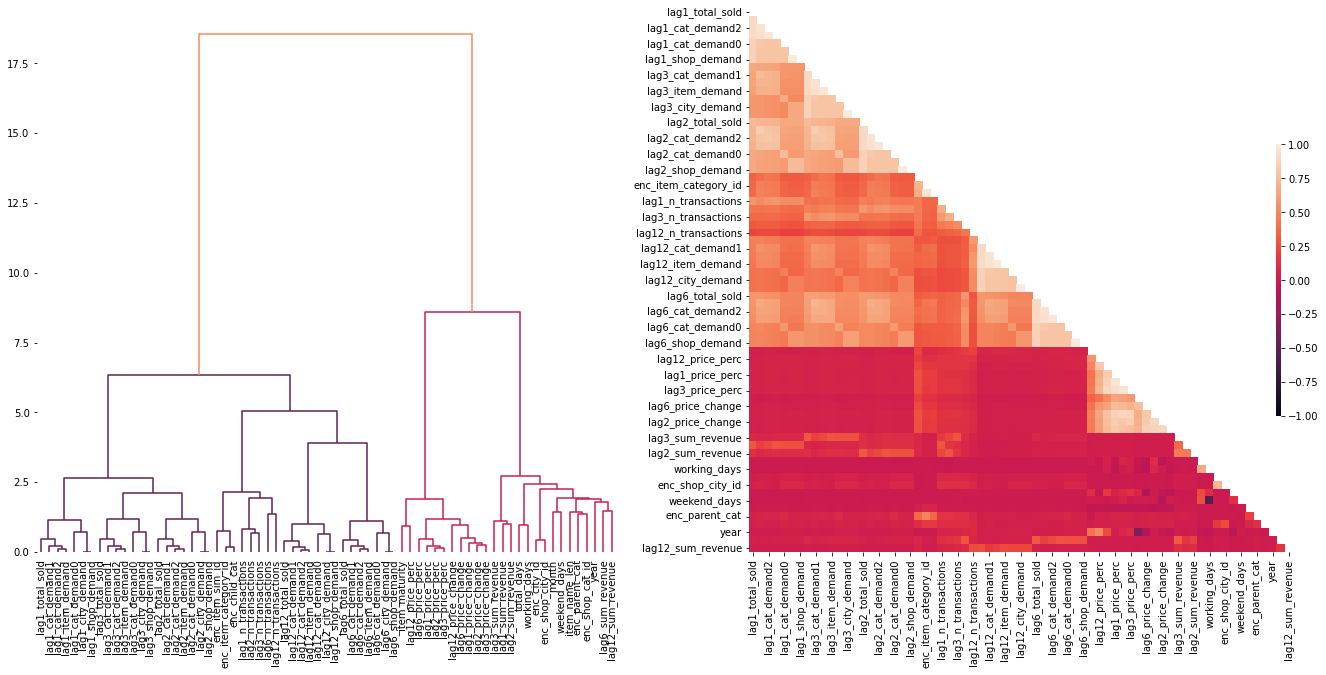

In [25]:
# take a peek at feature similarity
from scipy.cluster import hierarchy
corr_mat=sales.loc[:,features].corr()
corr_linkage = hierarchy.ward(corr_mat)
fig, axs = plt.subplots(1, 2, figsize=(24, 10),
  gridspec_kw={"width_ratios": [1, 1.15], "wspace":0.15})
color_links = [rgb2hex(c) for c in sns.color_palette("rocket", n_colors=3)]
hierarchy.set_link_color_palette(color_links)
dendro = hierarchy.dendrogram(corr_linkage, labels=corr_mat.columns,
    ax=axs[0], leaf_font_size=10, leaf_rotation=90,
    above_threshold_color=color_links[2])
hierarchy.set_link_color_palette(None)    
for s in axs[0].spines.keys():
    axs[0].spines[s].set_visible(False)
dendro_idx = np.arange(0, len(dendro["ivl"]))
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(corr_mat.iloc[dendro["leaves"], :].iloc[:, dendro["leaves"]],
    ax=axs[1], vmin=-1, vmax=1, mask=mask, square=True,
    cbar_kws={"aspect":50, "shrink":0.5, "pad":-0.025,
      "ticks":[-1,-.75,-0.5,-0.25,0,0.25,0.5,.75,1]}, annot_kws={"size":10})
axs[1].set_ylabel(""); axs[1].set_xlabel("");

In [26]:
# remove very similar feats
from collections import defaultdict
cluster_ids = hierarchy.fcluster(corr_linkage, .10, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
fs = [v[0] for v in cluster_id_to_feature_ids.values()]
features = corr_mat.columns[fs]
corr_mat.columns[fs] # print-out what is left

Index(['enc_item_category_id', 'enc_item_sim_id', 'enc_parent_cat',
       'enc_child_cat', 'enc_city_id', 'enc_shop_cat_id', 'enc_shop_city_id',
       'item_name_len', 'year', 'month', 'total_days', 'working_days',
       'weekend_days', 'item_maturity', 'lag1_total_sold', 'lag1_sum_revenue',
       'lag1_n_transactions', 'lag1_price_change', 'lag1_price_perc',
       'lag1_city_demand', 'lag1_cat_demand0', 'lag1_cat_demand1',
       'lag1_cat_demand2', 'lag1_item_demand', 'lag2_total_sold',
       'lag2_sum_revenue', 'lag2_n_transactions', 'lag2_price_change',
       'lag2_price_perc', 'lag2_city_demand', 'lag2_cat_demand0',
       'lag2_cat_demand1', 'lag2_cat_demand2', 'lag2_item_demand',
       'lag3_total_sold', 'lag3_sum_revenue', 'lag3_n_transactions',
       'lag3_price_change', 'lag3_price_perc', 'lag3_city_demand',
       'lag3_cat_demand0', 'lag3_cat_demand1', 'lag3_cat_demand2',
       'lag3_item_demand', 'lag6_total_sold', 'lag6_sum_revenue',
       'lag6_n_transactions'

In [27]:
corr_target = sales[features.union([target])].corr()[target]
print("\nHigh positive corr>")
display(corr_target.sort_values().tail(10))
print("\nHigh negative corr>")
display(corr_target.sort_values().head(10))
print("\nLow corr>")
display(corr_target.abs().sort_values().head(10))


High positive corr>


lag1_cat_demand0       0.362881
lag6_n_transactions    0.369238
lag1_cat_demand2       0.377458
lag1_total_sold        0.381043
lag1_item_demand       0.388877
enc_item_sim_id        0.412188
lag3_n_transactions    0.464969
lag2_n_transactions    0.525764
lag1_n_transactions    0.621674
total_sold             1.000000
Name: total_sold, dtype: float64


High negative corr>


working_days          0.002713
weekend_days          0.005942
total_days            0.008488
item_name_len         0.011510
month                 0.021843
year                  0.040610
lag12_sum_revenue     0.059449
enc_city_id           0.089175
lag12_price_change    0.094414
item_maturity         0.096808
Name: total_sold, dtype: float64


Low corr>


working_days          0.002713
weekend_days          0.005942
total_days            0.008488
item_name_len         0.011510
month                 0.021843
year                  0.040610
lag12_sum_revenue     0.059449
enc_city_id           0.089175
lag12_price_change    0.094414
item_maturity         0.096808
Name: total_sold, dtype: float64

In [28]:
# check variability
sales[features].var().sort_values().T

enc_city_id          8.671710e-03
enc_shop_cat_id      1.594336e-02
enc_shop_city_id     1.659593e-02
enc_parent_cat       2.590167e-02
enc_child_cat        9.540799e-02
                         ...     
lag12_sum_revenue    2.695919e+07
lag6_sum_revenue     3.159906e+07
lag3_sum_revenue     3.210717e+07
lag2_sum_revenue     3.267852e+07
lag1_sum_revenue     3.302674e+07
Length: 63, dtype: float64

In [29]:
# remove low correlated features (as they are also low in var)
#features = [f for f in features if f not in corr_target.abs().sort_values().head(10).index]
 # just remove some of the bs
sales = sales[sales.date_block_num>1]

## Modeling pipeline

In [30]:
import lightgbm as lgbm
import catboost as cat
import xgboost as xgb
from sklearn.linear_model import LinearRegression

In [31]:
# stage filters
b_ind =  sales.date_block_num==32 # 2nd stage 
c_ind =  sales.date_block_num==33 # eval
test_ind =  sales.date_block_num==34 # prediction
a_ind = ~b_ind & ~c_ind & ~test_ind # 1st stage

### First stage models

In [32]:
# lightgbm
lgbm_model = lgbm.LGBMRegressor(n_estimators=750, learning_rate=.005,
  max_depth=15, num_leaves=750, colsample_bytree=.7, subsample=0.7,
  subsample_freq=1, min_child_samples=1000, reg_alpha=105,
  reg_lambda=1.05, min_split_gain=10.0, max_bin=175,
  objective="rmse", device="gpu")
lgbm_model.fit(sales.loc[a_ind,features], sales.loc[a_ind,target],
  eval_set=(sales.loc[c_ind,features], sales.loc[c_ind,target]),
  callbacks=[lgbm.early_stopping(stopping_rounds=25)])

# pushout preds
lgbm_b_feature = lgbm_model.predict(sales.loc[b_ind,features]).clip(0,20)
lgbm_c_feature = lgbm_model.predict(sales.loc[c_ind,features]).clip(0,20)
lgbm_test_feature = lgbm_model.predict(sales.loc[test_ind,features]).clip(0,20)

Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.754847


In [33]:
# rf
rf_model = xgb.XGBRFRegressor(n_estimators=500, max_depth=15,
  colsample_bytree=0.75, subsample=0.75, colsample_bynode=0.5, reg_alpha=10,
  objective="reg:squarederror", tree_method="gpu_hist", gpu_id=0)
rf_model.fit(sales.loc[a_ind,features], sales.loc[a_ind,target],
  #eval_set=(sales.loc[c_ind,features], sales.loc[c_ind,target]),             
  eval_metric="rmse")

# pushout preds
rf_b_feature = rf_model.predict(sales.loc[b_ind,features]).clip(0,20)
rf_c_feature = rf_model.predict(sales.loc[c_ind,features]).clip(0,20)
rf_test_feature = rf_model.predict(sales.loc[test_ind,features]).clip(0,20)

In [34]:
# clf
clf_model = xgb.XGBRFClassifier(tree_method="gpu_hist", gpu_id=0)
clf_target =  sales.loc[:,target]>5
clf_model.fit(sales.loc[a_ind,features], clf_target[a_ind])
  #eval_set=(sales.loc[c_ind,features], sales.loc[c_ind,target]))

# pushout preds
clf_b_feature = clf_model.predict_proba(sales.loc[b_ind,features])[:,1]
clf_c_feature = clf_model.predict_proba(sales.loc[c_ind,features])[:,1]
clf_test_feature = clf_model.predict_proba(sales.loc[test_ind,features])[:,1]

In [35]:
# catboost on raw data
#cb_features = [f.replace("enc_", "") for f in features]
#cat_model = cat.CatBoostRegressor(iterations=750,
#  learning_rate=.01, depth=12, min_data_in_leaf=1000, l2_leaf_reg=.001,
#  bagging_temperature=0.75, random_strength=0.25,
#  verbose=100, eval_metric="RMSE", early_stopping_rounds=25, task_type="GPU",
#  cat_features=cat_cols,)
#cat_model.fit(sales.loc[a_ind,cb_features], sales.loc[a_ind,target],
#  eval_set=(sales.loc[c_ind,cb_features], sales.loc[c_ind,target]))

# pushout preds
#cat_b_feature = cat_model.predict(sales.loc[b_ind,cb_features]).clip(0,20)
#cat_c_feature = cat_model.predict(sales.loc[c_ind,cb_features]).clip(0,20)
#cat_test_feature = cat_model.predict(sales.loc[test_ind,cb_features]).clip(0,20)

### Second stage model

In [36]:
b_features = np.stack([rf_b_feature, lgbm_b_feature], axis=1)
c_features = np.stack([rf_c_feature, lgbm_c_feature], axis=1)
test_features = np.stack([rf_test_feature, lgbm_test_feature], axis=1)

lr_model = LinearRegression(fit_intercept=False)
lr_model.fit(b_features, sales.loc[b_ind,target])

train_rsme = np.mean((lr_model.predict(b_features).clip(0,20)-sales.loc[b_ind,target])**2)**(1/2)
val_rsme = np.mean((lr_model.predict(c_features).clip(0,20)-sales.loc[c_ind,target])**2)**(1/2)
print("Stacked pipeline> RMSE on train set: {}; on val set: {}".format(train_rsme, val_rsme))

Stacked pipeline> RMSE on train set: 0.7446321873116236; on val set: 0.7576100368397195


In [37]:
lr_model.coef_

array([-0.39498978,  1.49330683])

In [38]:
test_mapping = pd.read_csv(DATA_DIR+"test.csv")
test_predictions = sales.loc[test_ind,["item_id", "shop_id"]]
test_predictions["item_cnt_month"] = lr_model.predict(test_features).clip(0,20)
test_predictions = test_mapping.merge(test_predictions, on=["item_id", "shop_id"],how="left").fillna(0)
test_predictions[["ID", "item_cnt_month"]].to_csv("data/submissions/submission.csv", index=False)
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f data/submissions/submission.csv -m "Add more cat interactions."

100% 5.31M/5.31M [00:00<00:00, 18.5MB/s]
Successfully submitted to Predict Future Sales

## Submission